In [ ]:
# compute_probabilities(compute_forward(t.S) - self.market.dividend, nearest_node, variance, True)



# def compute_p_down(esperance: float, forward: float, variance: float, alpha: float) -> float:
#         return(
#             esperance ** (-2) * (variance + forward**2)
#             - 1
#             - (alpha + 1) * (esperance ** (-1) * forward - 1)
#         ) / ((1 - alpha) * (alpha ** (-2) - 1))

# def compute_p_up(p_down: float, alpha: float, esperance: float = None
#                 , forward: float = None, dividend: bool = False) -> float:
#     if not dividend:
#         return p_down / alpha
#     else:
#         return ((alpha - 1)**(-1)) * ((esperance ** (-1)) * forward - 1 -
#                 ((alpha ** (-1)) - 1) * p_down)


Prix de l’option: 2.7613441575786157
Black-Scholes Price: 2.7995


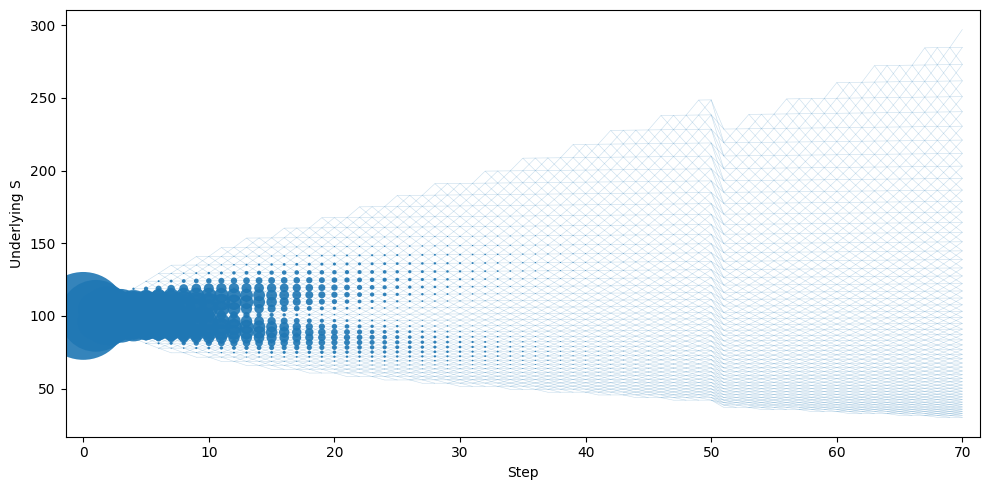

In [ ]:
from pricing import BlackScholesPricer, TrinomialTree, Market, Option
from pricing import convergence
from pricing import graphique
import datetime as dt
import sys

sys.setrecursionlimit(100000)
market = Market(S0=100, r=0.03, sigma=0.2, dividend=8, dividend_date=dt.datetime(2026, 1, 30))
option = Option(K=110, option_type="call", maturity=dt.datetime(2026, 10, 30), option_class="european")
tree = TrinomialTree(market, option, N=70, pruning=True, epsilon=1e-6)

price = tree.price(option)
print("Prix de l’option:", price)

bs_price = BlackScholesPricer().price(S=market.S0, K=option.K, T=tree.delta_t*tree.N, r=market.r, sigma=market.sigma, option_type='call', dividend=market.dividend, dividend_date = market.dividend_date) # q=0 car pas de dividendes
print("Black-Scholes Price: {:.4f}".format(bs_price))
# tree.plot_quick_tree()
graphique.plot_tree(tree.root)
# convergence.bs_convergence_by_strike(market, option, [80, 90, 100, 110, 120, 130, 140, 150, 160], N=100)

# convergence.bs_convergence_by_step(market, option, bs_price, max_n = 1000, step = 20)

In [ ]:
# soutenance sur teams de 30 min
# 2 quizz jusqu'à 17h le 29/10 : un qualitatif -> questions et un quantitatif où on va 
# devoir utiliser notre code pour répondre (possible de faire un ajout de code aussi)
# exemple qualitatif : quelle est le plus gros reproche de l'abre trinomial

pricer backward :
- calcul avec une boucle for sans limite de récursion
- on commence les calculs par le noeud de la fin
- allez à la fin avec les truncs nodes
- on calcul la valeur intrinsèque dans la dernière colonne
- on va ajouter le fait de revenir un cran en arrière sur le noeud tronc
- on peut avoir une classe TruncNode qui dérive de Node
- il faut aussi que n'importe quelle noeud de la colonne connaisse son TruncNode
- ensuite on remonte noeud par noeud et utilise la même fonction price que le récursif (la même forme)

problème des probas pas dans 0, 1:
il faut que le noeud mid soit le plus proche de l'espérance --> il faut changer de noeud mid quand ça dépasse 1 ou en dessous de 0
il va falloir attribuer next_mid en cherchant autour
lui sa construction il l'a fait en montant petit à petit dans les deux colonnes t et t+1 en même temps
tant que le next_mid est entre le next_mid actuel et la moyenne entre next_mid et next_up alors on garde ce next_mid sinon on attribue next_mid comme étant next_up, attribuer next_mid au noeud le plus proche de l'espérance --> calculer la moyenne entre le deux noeuds possible
le problème vient des noeuds du bas avec des valeur négative quand on soustrait le div--> résolu par le pruning qui enlève beaucoup de noeuds du bas

il faudrait que la colonne t sache que la colonne t+1 reçoit le dividende

REGARDER LES GRAPHS LOG LOG AVANT DE FAIRE LE PRUNING

Pruning : 
- soit proba d'arriver au noeud
- soit nombre d'écart type de S avec le trunc node (4 écarts types)
- chaque noeud à sa proba
- chaque noeud vient peut être de 3 noeud, à chaque fois qu'on fait une liaison vers ce noeud on rajoute à la proba cumulé du noeud vers lequel on va la contribution du noeud parent : next_down.proba_cumulée = next_down.proba_cumulée + current_node.proba ---> méthode dans Node
quand on monte dans l'arbre et que c'est trop petit, on fait juste un next_mid avec une proba de 1 ---> monomial ---> tant que c'est trop petit ---> monomial
le noeud qui a une proba faible crée un noeud monomial ! il existe mais ne crée pas plusieurs noeud c'est tout
- autre méthode = écart type

delta: prix_option en S0+epsilon (dans le temps) + prix_option en S0-epsilon/ 2*epsilon
c'est au QCM ça.
Les risk managers font des delta en pourcentage de la valeur du produit pour avoir des calls en % pour pouvoir comparer des produits similaires. Le epsilon est par exemple 1% de la valeur du produit. epsilon = 0.4 pour un produit à 40 et 4 pour un produit à 400 (décalage d'1%)
Il faudra utiliser la première méthode pour le QCM.

Gamma: dérivé du delta donc --> delta+ - delta- si unité de 1 de décalage
Avec un epsilon : (delta+(de epsilon) - delta-)/epsilon
à partir du prix = (Prixoption(S0 + epsilon) + Prixoption(S0-epsilon) - 2*Prixoption(S0)) / epsilon^2

Vega : (dérivé du prix par sigma) * 1%
 = (PrixS0 + 1% - PrixS0 - 1%)/2 car c'est de la vol

vega = dérivé seconde par rapport à la vol

vanna = dérivé croisée = dérivé du vega par rapport au spot = dérivée du delta par rapport à la vol


dérivée dans le code:
le callable est une fonction qui doit prendre un float en argument (valeur par rapport à laquelle on dérive)
shift = amplituyde de la variation